# Tutorial
This is a simply and concise tutorial to start using SimSpread, using as example dataset the classical "Iris"
dataset proposed by R.A. Fisher.

First, we must install the necesary packages we will use in this tutorial:

In [1]:
import Pkg; Pkg.add(["DelimitedFiles", "NamedArrays", "DataFrames", "Chain", "AlgebraOfGraphics", "CairoMakie", "ColorSchemes"])
Pkg.add(url="https://github.com/cvigilv/SimSpread.jl.git", rev="develop")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
    Updating git-repo `https://github.com/cvigilv/SimSpread.jl.git`
   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [afa5cc60] ~ SimSpread v0.1.0 `https://github.com/cvigilv/SimSpread.jl.git#develop` ⇒ v0.1.0 `https://github.com/cvigilv/SimSpread.jl.git#develop`
    Updating `~/.julia/environments/v1.9/Manifest.toml`
  [afa5cc60] ~ SimSpread v0.1.0 `https://github.com/cvigilv/SimSpread.jl.git#develop` ⇒ v0.1.0 `https://github.com/cvigilv/SimSpread.jl.git#develop`
Precompiling project...
  ✓ SimSpread
  1 dependency successfully precompiled in 4 seconds. 324 already precompiled.


In [2]:
using NamedArrays, DelimitedFiles

function url2namedmatrix(url; delim = "\t")
    M = readdlm(download(url, delim))
    
    sources = String.(M[1, begin:end-1])
    targets = String.(M[begin+1:end, 1])
    adjacency = Matrix{Float64}(M[begin+1:end, begin+1:end])
    
    return NamedArray(adjacency', (sources, targets))
end

# http://web.kuicr.kyoto-u.ac.jp/supp/yoshi/drugtarget/
DT = url2namedmatrix("http://web.kuicr.kyoto-u.ac.jp/supp/yoshi/drugtarget/nr_admat_dgc.txt")
DD = url2namedmatrix("http://web.kuicr.kyoto-u.ac.jp/supp/yoshi/drugtarget/nr_simmat_dc.txt");

## Data splitting

In [3]:
using SimSpread

# Split dataset in 10 groups and keep first
test_idx = first(split(DT, 5; seed = 0))
train_idx = [s for s in names(DT,1) if s ∉ test_idx]

# Split features and interactions
Xtrain = DD[train_idx, train_idx]
Xtest  = DD[test_idx, train_idx]
ytrain = DT[train_idx, :]
ytest  = DT[test_idx, :]

println("Training set:")
display(Xtrain[1:5, :])
display(ytrain[1:5, :])
println("\nTesting set:")
display(Xtest[1:5, :])
display(ytest[1:5, :])

Training set:


5×44 Named Matrix{Float64}
 A ╲ B │   D00040    D00066    D00067  …    D02217    D04066    D05341
───────┼──────────────────────────────────────────────────────────────
D00040 │      1.0  0.545455  0.297297  …     0.125  0.295455  0.095238
D00066 │ 0.545455       1.0  0.387097     0.115385       0.3     0.025
D00067 │ 0.297297  0.387097       1.0         0.25   0.53125  0.027027
D00075 │  0.53125  0.833333  0.464286     0.098039  0.351351  0.026316
D00088 │ 0.459459  0.689655  0.352941  …  0.150943   0.27907  0.047619

5×26 Named Matrix{Float64}
 A ╲ B │  hsa190  hsa2099  hsa2100  …  hsa8856  hsa9970  hsa9971
───────┼────────────────────────────────────────────────────────
D00040 │     0.0      0.0      0.0  …      0.0      0.0      0.0
D00066 │     0.0      1.0      0.0         0.0      0.0      0.0
D00067 │     0.0      1.0      0.0         0.0      0.0      0.0
D00075 │     0.0      0.0      0.0         0.0      0.0      0.0
D00088 │     0.0      0.0      0.0  …      0.0      0.0      0.0


Testing set:


5×44 Named Matrix{Float64}
 A ╲ B │   D00040    D00066    D00067  …    D02217    D04066    D05341
───────┼──────────────────────────────────────────────────────────────
D01132 │ 0.104167  0.116279      0.25  …  0.304348  0.285714   0.04878
D02367 │ 0.378378    0.4375   0.30303     0.115385  0.238095  0.051282
D00627 │ 0.080645  0.050847  0.113208     0.254237  0.152542      0.14
D00182 │ 0.428571  0.607143  0.448276     0.096154  0.307692  0.025641
D00951 │ 0.473684       0.7  0.297297  …  0.105263  0.295455  0.022222

5×26 Named Matrix{Float64}
 A ╲ B │  hsa190  hsa2099  hsa2100  …  hsa8856  hsa9970  hsa9971
───────┼────────────────────────────────────────────────────────
D01132 │     0.0      0.0      0.0  …      0.0      0.0      0.0
D02367 │     0.0      1.0      0.0         0.0      0.0      0.0
D00627 │     0.0      0.0      0.0         0.0      0.0      0.0
D00182 │     0.0      0.0      0.0         0.0      0.0      0.0
D00951 │     0.0      0.0      0.0  …      0.0      0.0      0.0

## Meta-description construction

In [4]:
# Generate meta-description from similarity measurements
α = 0.5
Xtrain′ = featurize(Xtrain, α, true)
Xtest′ = featurize(Xtest, α, true)

# Construct feature-source-target graph for predictions
G = construct(ytrain, ytest, Xtrain′, Xtest′)
display(first(G))

124×124 Named Matrix{Float64}
  A ╲ B │   D01132    D02367    D00627  …   hsa8856   hsa9970   hsa9971
────────┼──────────────────────────────────────────────────────────────
D01132  │      0.0       0.0       0.0  …       0.0       0.0       0.0
D02367  │      0.0       0.0       0.0          0.0       0.0       0.0
D00627  │      0.0       0.0       0.0          0.0       0.0       0.0
D00182  │      0.0       0.0       0.0          0.0       0.0       0.0
D00951  │      0.0       0.0       0.0          0.0       0.0       0.0
D01441  │      0.0       0.0       0.0          0.0       0.0       0.0
D01387  │      0.0       0.0       0.0          0.0       0.0       0.0
D00961  │      0.0       0.0       0.0          0.0       0.0       0.0
D00506  │      0.0       0.0       0.0          0.0       0.0       0.0
D01115  │      0.0       0.0       0.0          0.0       0.0       0.0
D00040  │      0.0       0.0       0.0          0.0       0.0       0.0
⋮                ⋮         ⋮      

## Target prediction with SimSpread

In [5]:
# Predict
ŷtrain = predict(G, ytrain; GPU = true)
ŷtest = predict(G, ytest; GPU = true)

10×26 Named Matrix{Float64}
 A ╲ B │     hsa190     hsa2099  …     hsa9970     hsa9971
───────┼──────────────────────────────────────────────────
D01132 │        0.0         0.0  …         0.0         0.0
D02367 │        0.0    0.146243            0.0         0.0
D00627 │        0.0         0.0            0.0         0.0
D00182 │        0.0    0.306052            0.0  0.00545455
D00951 │        0.0    0.168493            0.0  0.00595042
D01441 │        0.0         0.0            0.0         0.0
D01387 │        0.0  0.00466831            0.0         0.0
D00961 │        0.0         0.0            0.0         0.0
D00506 │        0.0         0.0            0.0         0.0
D01115 │        0.0   0.0180301  …         0.0         0.0

## Assesing predictive performance



In [6]:
using DataFrames

preds = DataFrame(alpha = [], lig = [], trg = [], yhat = [], y = [], train = [])

for (st, score) in enamerate(ŷtrain)
    s,t = st
    push!(preds, [α, s, t, score, ytrain[s, t], true])
end

for (st, score) in enamerate(ŷtest)
    s,t = st
    push!(preds, [α, s, t, score, ytest[s, t], false])
end

first(preds, 5)

Row,alpha,lig,trg,yhat,y,train
,Any,Any,Any,Any,Any,Any
1,0.5,D00040,hsa190,0.0,0.0,true
2,0.5,D00066,hsa190,0.0,0.0,true
3,0.5,D00067,hsa190,0.0,0.0,true
4,0.5,D00075,hsa190,0.0,0.0,true
5,0.5,D00088,hsa190,0.0,0.0,true


In [7]:
gpreds = groupby(preds, [:lig, :train])
perf = combine(
    gpreds, 
    [:y, :yhat] => ((x,y) -> SimSpread.AuROC(Bool.(x), Float64.(y))) => "AuROC",
    [:y, :yhat] => ((x,y) -> SimSpread.AuPRC(Bool.(x), Float64.(y))) => "AuPRC",
    [:y, :yhat] => ((x,y) -> SimSpread.BEDROC(Bool.(x), Float64.(y))) => "BEDROC",
)

Row,lig,train,AuROC,AuPRC,BEDROC
,Any,Any,Float64,Float64,Float64
1,D00040,true,0.96,0.25,0.463369
2,D00066,true,1.0,0.5,1.0
3,D00067,true,1.0,0.0,1.0
4,D00075,true,1.0,0.0,1.0
5,D00088,true,1.0,0.0,1.0
6,D00094,true,1.0,0.888889,1.0
7,D00105,true,1.0,0.5,1.0
8,D00129,true,1.0,0.0,1.0
9,D00143,true,1.0,0.0,1.0


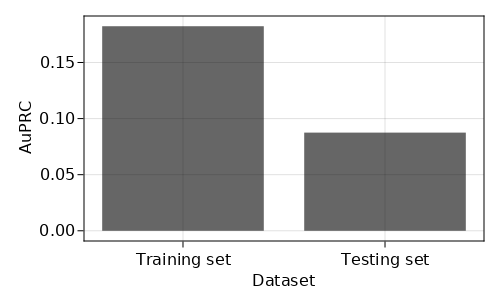

In [8]:
using AlgebraOfGraphics, CairoMakie

# Evaluate predictions
plt = data(perf)
plt *= expectation()
plt *= mapping(
    :train => renamer(true => "Training set", false => "Testing set") => "Dataset", 
    :AuPRC
)

draw(plt; axis = (width = 400, height = 225))

# Wrapping it all up

In [25]:
using Chain, ColorSchemes, Statistics

# Initialize accumulator dataframe
allpreds = DataFrame(alpha = [], lig = [], trg = [], yhat = [], y = [], train = [])

for α in 0.0:0.05:1.0
    # Generate meta-description from similarity measurements
    Xtrain′ = featurize(Xtrain, α, true)
    Xtest′ = featurize(Xtest, α, true)

    # Construct feature-source-target graph for predictions
    G = construct(ytrain, ytest, Xtrain′, Xtest′)
    
    # Predict interactions
    ŷtrain = predict(G, ytrain; GPU = true)
    ŷtest = predict(G, ytest; GPU = true)
    
    # Clean predictions
    clean!(ŷtrain, first(G), ytrain)
    clean!(ŷtest, first(G), ytest)
    
    # Store predictions in dataframe
    for (st, score) in enamerate(ŷtrain)
        if score ≠ -99.0
        s,t = st
        push!(allpreds, [α, s, t, score, Bool(ytrain[s, t]), true])
        end
    end

    for (st, score) in enamerate(ŷtest)
        if score ≠ -99.0
        s,t = st
        push!(allpreds, [α, s, t, score, Bool(ytest[s, t]), false])
        end
    end
end

# Evaluate predictions
perf_table = @chain allpreds begin
    # Calculate performace per ligand
    groupby([:alpha, :lig, :train])
    combine(
        [:y, :yhat] => ((x,y) -> SimSpread.AuROC(Bool.(x), Float64.(y))) => "AuROC",
        [:y, :yhat] => ((x,y) -> SimSpread.AuPRC(Bool.(x), Float64.(y))) => "AuPRC",
        [:y, :yhat] => ((x,y) -> SimSpread.BEDROC(Bool.(x), Float64.(y))) => "BEDROC",
        [:y, :yhat, :lig] => ((x,y,z) -> SimSpread.recallatL(Bool.(x), Float64.(y), String.(z))) => "R@20",
        [:y, :yhat, :lig] => ((x,y,z) -> SimSpread.precisionatL(Bool.(x), Float64.(y), String.(z), 20)) => "P@20",
        [:yhat] => SimSpread.validity_ratio => "Ratio of valid predictions",
    )
    # Convert widt-to-long format
    stack(
        Not([:alpha, :lig, :train]), 
        [:alpha, :lig, :train], 
        variable_name = "metric",
        value_name = "performance"
    )
end

Row,alpha,lig,train,metric,performance
,Any,Any,Any,String,Float64
1,0.0,D00040,true,AuROC,0.958333
2,0.0,D00066,true,AuROC,1.0
3,0.0,D00067,true,AuROC,1.0
4,0.0,D00075,true,AuROC,0.958333
5,0.0,D00088,true,AuROC,0.958333
6,0.0,D00094,true,AuROC,1.0
7,0.0,D00105,true,AuROC,1.0
8,0.0,D00129,true,AuROC,1.0
9,0.0,D00143,true,AuROC,0.958333


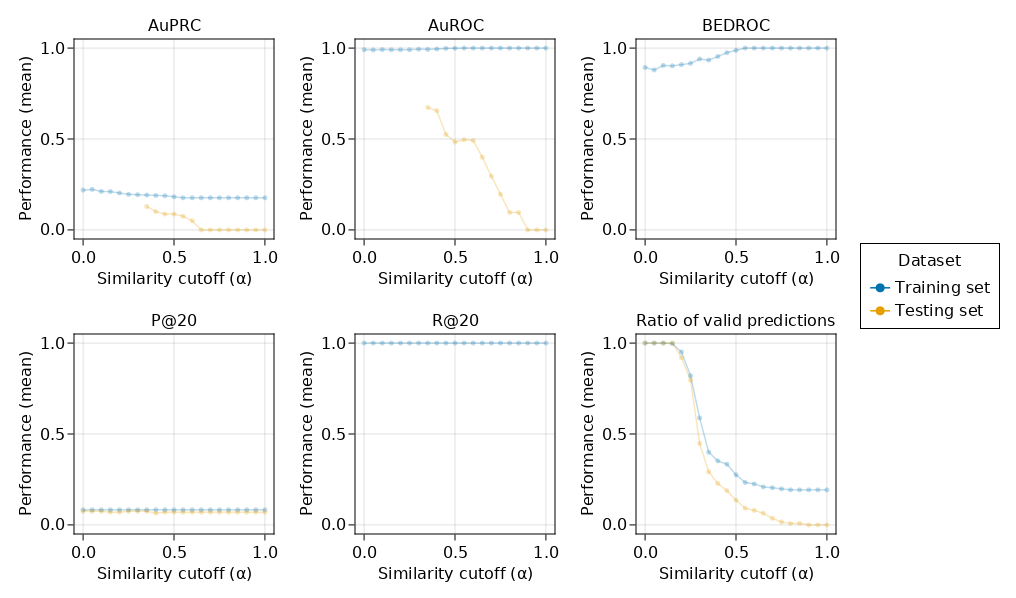

In [28]:
# Plot results
plt = data(perf_table)
plt *= expectation() * (visual(Lines, alpha = 0.25) + visual(Scatter, markersize=5, alpha = 0.25))
plt *= mapping(
    :alpha => "Similarity cutoff (α)",
    :performance=> "Performance (mean)",  
)
plt *= mapping(
    color = :train => renamer(true => "Training set", false => "Testing set") => "Dataset", 
    layout = :metric
)

draw(
    plt; 
    axis = (width = 200, height = 200, limits=(nothing, nothing)),
)